In [34]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib as plt
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from nltk.corpus import stopwords

In [35]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [36]:
RUTA_GUARDADO = "predicciones.csv"

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Aqui ya observamos que el dataset no contiene nulos

In [38]:
df_train.head(10)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
5,5,Probablemente mi película favorita de todos lo...,positivo
6,6,Seguro que me gustaría ver una resurrección de...,positivo
7,7,"Este espectáculo fue una idea increíble, fresc...",negativo
8,8,Alentados por los comentarios positivos sobre ...,negativo
9,9,"Si te gusta la risa original desgarradora, te ...",positivo


In [39]:
df_test.head(3)

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...


<Axes: xlabel='sentimiento', ylabel='count'>

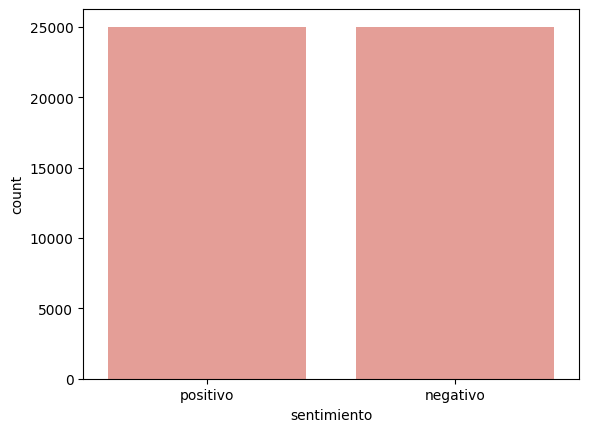

In [40]:
sns.countplot(x=df_train["sentimiento"], color="#F1948A")

In [41]:
df_train["sentimiento"].value_counts()

sentimiento
positivo    25000
negativo    25000
Name: count, dtype: int64

In [42]:
df_train["sentimiento"] = df_train["sentimiento"].map({"positivo": 1, "negativo": 0})

In [47]:
def normalizar_texto(df, columna):
    reemplazos = {"á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"}
    df[columna] = df[columna].str.lower()
    for clave, valor in reemplazos.items():
        df[columna] = df[columna].str.replace(clave, valor)
    return df[columna]

In [14]:
#df_train["review_es"], df_test["review_es"] = normalizar_texto(df_train, "review_es"), normalizar_texto(df_test, "review_es")

In [48]:
df_train_train, df_train_test = train_test_split(df_train, test_size=0.3, random_state=33)

In [49]:
x_train, y_train, x_test_, y_test_ = df_train_train["review_es"], df_train_train["sentimiento"], df_train_test["review_es"], df_train_test["sentimiento"]

In [56]:
x_test = df_test["review_es"]

In [57]:
from sklearn.model_selection import GridSearchCV

In [58]:
def busqueda_hiperparametros(modelo, x_vectorizado):
  param_grid = {
    "alpha": [0.6, 0.7, 0.8],
    "binarize": [0.0],
    "fit_prior": [True],
    "class_prior": [[0.2,0.6], [0.1,0.5], [0.2,0.7]]
  }
  
  grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=10, scoring="f1_macro")
  
  print(y_train)

  grid_search.fit(x_vectorizado, y_train)

  return grid_search

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [60]:
def imprimir_resultados(y, y_pred):

    labels = [0, 1]

    f1 = f1_score(y, y_pred, pos_label=1, labels=labels)
    precision = precision_score(y, y_pred, pos_label=1, labels=labels)
    recall = recall_score(y, y_pred, pos_label=1, labels=labels)
    accuracy = accuracy_score(y, y_pred)

    cm = confusion_matrix(y_test_, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

    print(f"F1: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")

In [73]:
def guardar_resultado_en_csv(prediccion):

    f = lambda e: "positivo" if e == 1 else "negativo"
    f = np.vectorize(f)
    prediccion = f(prediccion)

    df_predicciones = pd.DataFrame({"ID": df_test["ID"], "prediccion": prediccion})

    df_predicciones.to_csv(RUTA_GUARDADO, header=["ID", "sentimiento"], index=False)

In [62]:
vectorizer = CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test_)

## Bernoulli Naive Bayes

In [63]:
# Dejando stopwords

nb_classifier = BernoulliNB()
gs = busqueda_hiperparametros(nb_classifier, x_train_vec)

24349    1
9986     0
35718    1
39846    1
34761    1
        ..
27282    1
578      0
38616    1
2439     1
23572    0
Name: sentimiento, Length: 35000, dtype: int64


In [64]:
print(gs.best_params_)

{'alpha': 0.8, 'binarize': 0.0, 'class_prior': [0.1, 0.5], 'fit_prior': True}


In [65]:
best_nb = BernoulliNB(alpha=gs.best_params_["alpha"], fit_prior=gs.best_params_["fit_prior"])

gs.fit(x_train_vec, y_train)
y_pred = gs.predict(x_test_vec)

F1: 0.8535300316122234
Precision: 0.8393782383419689
Recall: 0.8681672025723473
Accuracy: 0.8517333333333333


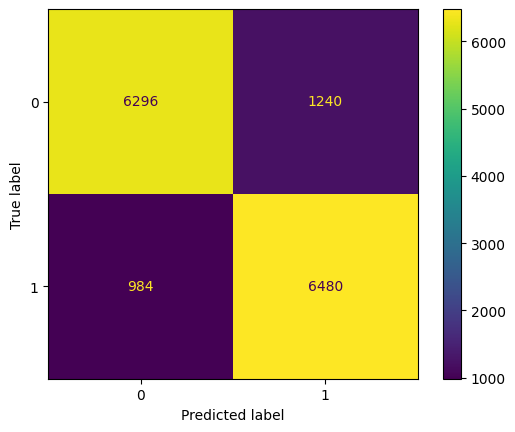

In [66]:
imprimir_resultados(y_test_, y_pred)

In [67]:
y_pred_ = gs.predict(vectorizer.transform(x_test))

In [74]:
guardar_resultado_en_csv(y_pred_)

## Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [76]:
def func_classif(param_distributions, cv, scoring, estimator, n_iter):
  randomcv = RandomizedSearchCV(estimator=estimator,
                                param_distributions = param_distributions,
                                scoring=scoring,
                                cv=cv,
                                n_jobs = -1,
                                n_iter=n_iter,
                                random_state=33)

  randomcv.fit(x_train_vec, y_train)

  return randomcv

In [77]:
n_iter = 5

param_distributions = { 
    "criterion" : ["gini", "entropy", "log_loss"],
    "min_samples_leaf" : [1, 5, 10],
    "min_samples_split" : [2, 4, 10, 12, 16],
    "n_estimators": [10, 20, 50, 70, 100],
    "max_depth": range(15, 50) }


cv = StratifiedKFold(n_splits=5)

scoring = "accuracy"

estimator = RandomForestClassifier(random_state=33)

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)

In [78]:
best_rf = randomcv.best_estimator_

In [79]:
best_params_rf = randomcv.best_params_

In [80]:
best_rf = RandomForestClassifier(
            criterion=best_params_rf["criterion"],
            min_samples_leaf=best_params_rf["min_samples_leaf"],
            min_samples_split=best_params_rf["min_samples_split"],
            n_estimators=best_params_rf["n_estimators"],
            max_depth=best_params_rf["max_depth"])

In [81]:
best_rf.fit(x_train_vec, y_train)

y_pred = best_rf.predict(x_test_vec)

F1: 0.8436662964656693
Precision: 0.82328190743338
Recall: 0.865085744908896
Accuracy: 0.8404666666666667


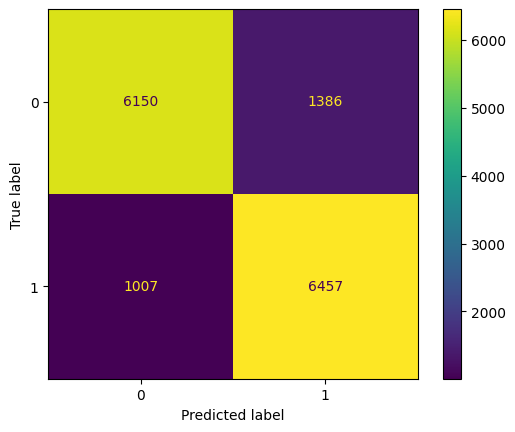

In [82]:
imprimir_resultados(y_test_, y_pred)

In [83]:
y_pred_ = best_rf.predict(vectorizer.transform(x_test))

In [84]:
guardar_resultado_en_csv(y_pred_)

## XGBoost

In [90]:
from xgboost import XGBClassifier

In [93]:
n_iter = 5

param_distributions = { 
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4],
    "max_depth": [3, 4, 5, 7],
    "n_estimators": [100, 200, 300] 
    }

cv = StratifiedKFold(n_splits=5)

scoring = "accuracy"

estimator = XGBClassifier(random_state=33)

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)

In [94]:
best_params_xgboost = randomcv.best_params_

In [95]:
best_xgboost = XGBClassifier(learning_rate=best_params_xgboost["learning_rate"],
                        n_estimators=best_params_xgboost["n_estimators"],
                        max_depth=best_params_xgboost["max_depth"])

In [96]:
best_xgboost.fit(x_train_vec, y_train)

y_pred = best_xgboost.predict(x_test_vec)

F1: 0.860801707463483
Precision: 0.8570859343870368
Recall: 0.8645498392282959
Accuracy: 0.8608666666666667


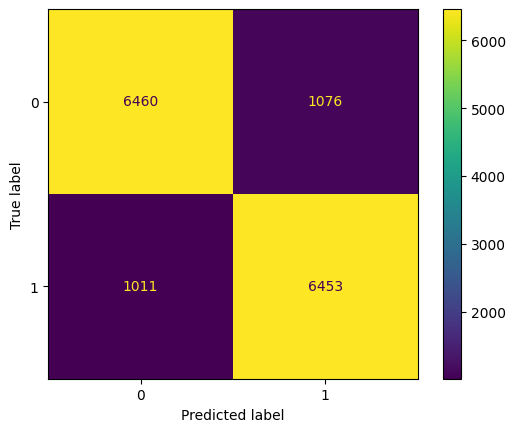

In [97]:
imprimir_resultados(y_test_, y_pred)

In [98]:
y_pred_ = best_xgboost.predict(vectorizer.transform(x_test))

In [99]:
y_pred_ = np.where(y_pred_ == 0, "negativo", "positivo")

In [100]:
guardar_resultado_en_csv(y_pred_)

## Red neuronal

## Ensamble

Pruebo sacando los stopwords

In [101]:
# nltk.download("stopwords")
# nltk.download("punkt")
# stop_words = set(stopwords.words("spanish"))

In [102]:
# def limpiar_reseña(reseña):
#     palabras = word_tokenize(reseña.lower())
#     palabras_filtradas = [word for word in palabras if word not in stop_words]
#     return " ".join(palabras_filtradas)

In [103]:
# # Sacando stopwords

# x_train_ = [limpiar_reseña(reseña) for reseña in x_train]
# x_train_ = pd.Series([limpiar_reseña(reseña) for reseña in x_train])

In [104]:
# vectorizer = CountVectorizer()
# x_train_vec_ = vectorizer.fit_transform(x_train_)
# x_test_vec_ = vectorizer.transform(x_test)

# nb_classifier = BernoulliNB()
# nb_classifier.fit(x_train_vec_, y_train)

# gs = busqueda_hiperparametros(nb_classifier, x_train_vec)

# best_nb = BernoulliNB(alpha=gs.best_params_["alpha"], fit_prior=gs.best_params_["fit_prior"])

# best_nb.fit(x_train_vec_, y_train)


# y_pred = best_nb.predict(x_test_vec_)

# guardar_resultado_en_csv(y_pred)